In [1]:
# Load Packages
from datetime import date, datetime, timedelta
import calendar
import pandas as pd
import numpy as np
import itertools
import copy
from numpy.linalg import multi_dot
from scipy.stats import norm
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import math
from arch.bootstrap import SPA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

#Import Date opertative user defined functions
from ipynb.fs.full.user_defined_vik_functions import get_all_monthly_option_expiries, \
                                                     find_last_thurs_date_of_month, \
                                                     prev_workday_if_holiday, find_wkly_expries,\
                                                     date_of_prev_thurs, generate_daily_dates_each_month, \
                                                     next_workday, next_weekday, \
                                                     create_df_wk_days, find_week, date_of_next_thurs

# Import dataframe naming functions 
from ipynb.fs.full.user_defined_vik_functions import get_mthly_df_name_from_expiry

#Import data loading functions
from ipynb.fs.full.user_defined_vik_functions import load_all_mthly_data



In [2]:
# Optimal Block Length
def single_optimal_block(x):
    """
    Compute the optimal window length for a single series

    Parameters
    ----------
    x : ndarray
        The data to use in the optimal window estimation

    Returns
    -------
    stationary : float
        Estimated optimal window length for stationary bootstrap
    circular : float
        Estimated optimal window length for circular bootstrap
    """
    nobs = x.shape[0]
    eps = x - x.mean(0)
    b_max = np.ceil(min(3 * np.sqrt(nobs), nobs / 3))
    kn = max(5, int(np.log10(nobs)))
    m_max = int(np.ceil(np.sqrt(nobs))) + kn
    # Find first collection of kn autocorrelations that are insignificant
    cv = 2 * np.sqrt(np.log10(nobs) / nobs)
    acv = np.zeros(m_max + 1)
    abs_acorr = np.zeros(m_max + 1)
    opt_m: Optional[int] = None
    for i in range(m_max + 1):
        v1 = eps[i + 1 :] @ eps[i + 1 :]
        v2 = eps[: -(i + 1)] @ eps[: -(i + 1)]
        cross_prod = eps[i:] @ eps[: nobs - i]
        acv[i] = cross_prod / nobs
        abs_acorr[i] = np.abs(cross_prod) / np.sqrt(v1 * v2)
        if i >= kn:
            if np.all(abs_acorr[i - kn : i] < cv) and opt_m is None:
                opt_m = i - kn
    m = 2 * max(opt_m, 1) if opt_m is not None else m_max
    m = min(m, m_max)

    g = 0.0
    lr_acv = acv[0]
    for k in range(1, m + 1):
        lam = 1 if k / m <= 1 / 2 else 2 * (1 - k / m)
        g += 2 * lam * k * acv[k]
        lr_acv += 2 * lam * acv[k]
    d_sb = 2 * lr_acv ** 2
    d_cb = 4 / 3 * lr_acv ** 2
    b_sb = ((2 * g ** 2) / d_sb) ** (1 / 3) * nobs ** (1 / 3)
    b_cb = ((2 * g ** 2) / d_cb) ** (1 / 3) * nobs ** (1 / 3)
    b_sb = min(b_sb, b_max)
    b_cb = min(b_cb, b_max)
    return b_sb, b_cb



def adf_test(timeseries):
    #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput


#define KPSS
def kpss_test(timeseries):
#     print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    return kpss_output



In [3]:
#Compute Daily Static  Hedging Errors

###################################
# Common Variables initialisation #
###################################

# Stock Index of Interest
# stock_ident = "BANKNIFTY"
stock_ident_list = ["NIFTY","BANKNIFTY"]

#Static hedging performed at different moneyness regions 
#i.e. moneyness is used to select the option with nearest moneyness match
# ATM - At the Money, ITM - In the money, OTM - Out of the Money
prod_moneyness_list = ["A", "I", "O"]

#Product type to hedge: either "CE" or "PE"
prod_type_list = ["C", "P"]
# prod_type = "PE"

e_Series = ["0", "0A", "0B", "0C", "1A", "2A", "3A", "4A"]

#Period: "covid", "normal", "full"
period = "covid"

if (period == "covid"):
    month_list = [date(2020, 2, 27), date(2020, 3, 26), date(2020, 4, 30), \
                  date(2020, 5, 28), date(2020, 6, 25), date(2020, 7, 30)]
elif (period == "normal"):
    month_list = [date(2019, 8, 29), date(2019, 9, 26), \
                date(2019, 10, 31), date(2019, 11, 28), \
                date(2019, 12, 26), date(2020, 1, 30)]
else:
    month_list = [date(2019, 8, 29), date(2019, 9, 26), \
                date(2019, 10, 31), date(2019, 11, 28), \
                date(2019, 12, 26), date(2020, 1, 30), \
                date(2020, 2, 27), date(2020, 3, 26), date(2020, 4, 30), \
                date(2020, 5, 28), date(2020, 6, 25), date(2020, 7, 30)]

mth_list = [monthly_dates.strftime("%d-%b-%Y") for monthly_dates in month_list]    


#Path to refer data
source_path = "/home/jupyter-partha/Vikranth - Chapter 2/"
input_sub_path = "Input Data/mkt_data_covid_region/"
output_sub_path = "Output Data/"
input_data_path = source_path + input_sub_path
output_data_path = source_path + output_sub_path
output_station_path = source_path + "doc_outputs/SPA_covid/Stationarity Tests/"
output_spa_path = source_path + "doc_outputs/SPA_covid/SPA/"

# Periods of interest will be a dictionary
#Key is the year, value is a list of months 1-12, 1- Jan, 2 - Feb,...12 - Dec
# For E.g., periods_of_interest = {2020: [3], 2019: [11, 12]}
periods_of_interest = {2019: [8, 9, 10, 11, 12], 2020: [1, 2, 3, 4, 5, 6, 7]}

#List of holidays
holidays_list = [date(2019, 3, 4), date(2019, 3, 21),\
                 date(2019, 4, 17), date(2019, 4, 19), date(2019, 4, 29),\
                 date(2019, 5, 1),\
                 date(2019, 6, 5),\
                 date(2019, 8, 12), date(2019, 8, 15),\
                 date(2019, 9, 2), date(2019, 9, 10), \
                 date(2019, 10, 2), date(2019, 10, 8), date(2019, 10, 21), date(2019, 10, 28), \
                 date(2019, 11, 12), \
                 date(2019, 12, 25), \
                 date(2020, 2, 21), \
                 date(2020, 3, 10), \
                 date(2020, 4, 2), date(2020, 4, 6), date(2020, 4, 10), date(2020,4, 14), \
                 date(2020, 5, 1), date(2020, 5, 25), \
                 date(2020, 10, 2), date(2020, 11, 16), date(2020, 11, 30), date(2020, 12, 25)]


In [4]:
case_list = list(itertools.product(e_Series, prod_moneyness_list, prod_type_list, stock_ident_list))

# NIFTY BANKNIFTY; CALL PUT; ATM ITM OTM;
# Losses - (All Option: Dynamic, CVOL, CSMILE, CSURF, FSMILE; Only Call: CarrWu) * (LINEAR_INTP, CUBIC_SPLINE, CUBIC_POLYN, QUAD_POLYN)


dfs_dict = {"CE_NIFTY_ATM": [], "CE_NIFTY_ITM": [], "CE_NIFTY_OTM": [], \
            "PE_NIFTY_ATM": [], "PE_NIFTY_ITM": [], "PE_NIFTY_OTM": [], \
            "CE_BANKNIFTY_ATM": [], "CE_BANKNIFTY_ITM": [], "CE_BANKNIFTY_OTM": [], \
            "PE_BANKNIFTY_ATM": [], "PE_BANKNIFTY_ITM": [], "PE_BANKNIFTY_OTM": []}

for case in case_list:
    if (case[1] == 'A'):
        prod_moneyness = "ATM"
    if (case[1] == 'I'):
        prod_moneyness = "ITM"    
    if (case[1] == 'O'):
        prod_moneyness = "OTM"
    if (case[2] == 'C'):
        prod_type = "CE"
    if (case[2] == 'P'):
        prod_type = "PE"
        
    if (case[0] in ["0", "1A"]):
        interpolation_type = "Linear Interpolation"
        intrpl_id = "linear"
    if (case[0] in ["0A", "2A"]):
        interpolation_type = "Cubic Spline Interpolation"
        intrpl_id = "cubic_spline"
    if (case[0] in ["0B", "3A"]):
        interpolation_type = "Cubic Polynomial Fit"
        intrpl_id = "cubic_polyn"
    if (case[0] in ["0C", "4A"]):
        interpolation_type = "Quadratic Polynomial Fit"
        intrpl_id = "quad_polyn"
    
    stock_ident = case[3]
  
    
    if (prod_type == "CE"):  
        
        if (case[0] in ["1A", "2A", "3A", "4A"]):
            filename = output_data_path + "E" + case[0] + "_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_hedge_results" + ".csv"
        
            df_hedge_data = pd.read_csv(filename)

            df_hedge_data = df_hedge_data[df_hedge_data.Month_Expiry.isin(mth_list)]
                
                
            no_of_rows = df_hedge_data.shape[0]
#             print(no_of_rows)

            df_hedge_data['Loss_dynamic_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - Dynamic'])
            df_hedge_data['Loss_constVol_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVol'])
            df_hedge_data['Loss_constSmile_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVolSmile'])
            df_hedge_data['Loss_constSurf_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVolSurf'])
            df_hedge_data['Loss_fwdSmile_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - FwdSmile'])

            df_loss = df_hedge_data[['Loss_dynamic_' + intrpl_id, 'Loss_constVol_' + intrpl_id, \
                                     'Loss_constSmile_' + intrpl_id, 'Loss_constSurf_' + intrpl_id, \
                                     'Loss_fwdSmile_' + intrpl_id]]

            dfs_dict[ prod_type + "_" + stock_ident + "_" + prod_moneyness].append(df_loss)
            
        if (case[0] in ["0", "0A", "0B", "0C"] and prod_type =="CE"):
            filename = output_data_path + "E" + case[0] + "_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_hedge_results" + ".csv"

            df_hedge_data = pd.read_csv(filename)
            

            df_hedge_data = df_hedge_data[df_hedge_data.Month_Expiry.isin(mth_list)]
            
            
            no_of_rows = df_hedge_data.shape[0]
#             print(no_of_rows)
            df_hedge_data['Loss_carrWu_' + intrpl_id] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - CarrWu'])
            df_loss = df_hedge_data[['Loss_carrWu_' + intrpl_id]]

            dfs_dict[prod_type + "_" + stock_ident + "_" + prod_moneyness].append(df_loss)
            
    else:
        
        if (case[0] in ["1A", "2A", "3A", "4A"]):
            filename = output_data_path + "E" + case[0] + "_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_hedge_results" + ".csv"
        
            df_hedge_data = pd.read_csv(filename)

            df_hedge_data = df_hedge_data[df_hedge_data.Month_Expiry.isin(mth_list)]
            
        
            no_of_rows = df_hedge_data.shape[0]
#             print(no_of_rows)

            df_hedge_data['Loss_dynamic_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - Dynamic'])
            df_hedge_data['Loss_constVol_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVol'])
            df_hedge_data['Loss_constSmile_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVolSmile'])
            df_hedge_data['Loss_constSurf_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVolSurf'])
            df_hedge_data['Loss_fwdSmile_' + intrpl_id] = (df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - FwdSmile'])

            df_loss = df_hedge_data[['Loss_dynamic_' + intrpl_id, 'Loss_constVol_' + intrpl_id, \
                                     'Loss_constSmile_' + intrpl_id, 'Loss_constSurf_' + intrpl_id, \
                                     'Loss_fwdSmile_' + intrpl_id]]
            
            dfs_dict[ prod_type + "_" + stock_ident + "_" + prod_moneyness].append(df_loss)

        
loss_df_dict =  {}

for df_list in dfs_dict.keys():
    loss_df_dict[df_list] = pd.concat(dfs_dict[df_list], axis=1)




In [5]:
# print(loss_df_dict["CE_NIFTY_ATM"]["Loss_constVol_linear"])

In [6]:

alternative_models = ["Loss_constVol_linear", "Loss_constVol_cubic_spline", "Loss_constVol_cubic_polyn", "Loss_constVol_quad_polyn", \
                      "Loss_constSmile_linear" , "Loss_constSmile_cubic_spline" , "Loss_constSmile_cubic_polyn" , "Loss_constSmile_quad_polyn" , \
                      "Loss_constSurf_linear", "Loss_constSurf_cubic_spline", "Loss_constSurf_cubic_polyn", "Loss_constSurf_quad_polyn", \
                      "Loss_fwdSmile_linear", "Loss_fwdSmile_cubic_spline", "Loss_fwdSmile_cubic_polyn", "Loss_fwdSmile_quad_polyn"]

carr_alt_models = ["Loss_carrWu_linear", "Loss_carrWu_cubic_spline", "Loss_carrWu_cubic_polyn", "Loss_carrWu_quad_polyn"]

dynamic_models = ["Loss_dynamic_linear", "Loss_dynamic_cubic_spline", "Loss_dynamic_cubic_polyn", "Loss_dynamic_quad_polyn"]


winner_ce_models = ["Loss_constVol_linear", "Loss_dynamic_linear", "Loss_carrWu_linear"]
winner_pe_models = ["Loss_constVol_linear", "Loss_dynamic_linear"]


In [7]:
# print(loss_df_dict.keys())

In [9]:
# #Stationary test
# loss_func = "absolute"
loss_func = "square"

######################################################
# 1. Dynamic Hedging Comparisons - Stationary Test ###
######################################################


total_models_list = alternative_models + dynamic_models 
benchmark_list = []
models_list = []
keys_list = []
adf_critical_value_list = []
adf_test_statistics_list = []
adf_pvalue_list = []
kpss_critical_value_list = []
kpss_test_statistics_list = []
kpss_pvalue_list = []
stationary_list = []



for model in dynamic_models:
    benchmark = model

    for key in loss_df_dict.keys():
        df = loss_df_dict[key]
        
        if (loss_func == "absolute"):
            bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark]).reshape(-1))
        else:
            bm_loss = np.square(np.array(loss_df_dict[key][benchmark]).reshape(-1))            
        
        updated_models = copy.deepcopy(dynamic_models)
        updated_models.remove(benchmark)
        
        
        for each_model in updated_models:

            if (loss_func == "absolute"):
                model_loss = np.absolute(np.array(loss_df_dict[key][[each_model]])).reshape(-1)
            else:
                model_loss = np.square(np.array(loss_df_dict[key][[each_model]])).reshape(-1)  
                
            perf = bm_loss - model_loss
            
            adf_model = adf_test(perf)
            kpss_model = kpss_test(perf)
            
            benchmark_list.append(benchmark)
            models_list.append(each_model)
            keys_list.append(key)
            adf_critical_value_list.append(adf_model["Critical Value (5%)"])
            adf_test_statistics_list.append(adf_model["Test Statistic"])
            adf_pvalue_list.append(adf_model["p-value"])
            kpss_critical_value_list.append(kpss_model["Critical Value (5%)"])
            kpss_test_statistics_list.append(kpss_model["Test Statistic"])
            kpss_pvalue_list.append(kpss_model["p-value"])            
            if (kpss_model["p-value"] >= 0.05 or adf_model["p-value"] < 0.05 or adf_model["p-value"] == ""):
                result = "Passed"
            else:
                result = "Failed"
            stationary_list.append(result)

df_dynamic_stationary = pd.DataFrame({"Benchmark": benchmark_list, "Model": models_list,\
                       "Scenario": keys_list, \
                       "ADF Critical Value": adf_critical_value_list, \
                        "ADF Test Statistics": adf_test_statistics_list, \
                        "ADF P-Value": adf_pvalue_list, \
                        "KPSS Critical Value": kpss_critical_value_list, \
                        "KPSS Test Statistics": kpss_test_statistics_list, \
                        "KPSS P-Value": kpss_pvalue_list, \
                        "Stationarity": stationary_list})            


df_dynamic_stationary.to_csv(output_station_path + "F2_" + "dynamic_stationary_" + loss_func + ".csv", index = False)



######################################################
# 1. CarrWu Hedging Comparisons - Stationary Test ###
######################################################


benchmark_list = []
models_list = []
keys_list = []
adf_critical_value_list = []
adf_test_statistics_list = []
adf_pvalue_list = []
kpss_critical_value_list = []
kpss_test_statistics_list = []
kpss_pvalue_list = []
stationary_list = []


for model in carr_alt_models:
    benchmark = model

    for key in loss_df_dict.keys():
        if (key[0:2] == "CE"):
            df = loss_df_dict[key]
        
            if (loss_func == "absolute"):
                bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark]).reshape(-1))
            else:
                bm_loss = np.square(np.array(loss_df_dict[key][benchmark]).reshape(-1))  

            updated_models = copy.deepcopy(carr_alt_models)
            updated_models.remove(benchmark)

            for each_model in updated_models:
                if (key[0:2] == "CE"):
                    
                    if (loss_func == "absolute"):
                        model_loss = np.absolute(np.array(loss_df_dict[key][[each_model]])).reshape(-1)
                    else:
                        model_loss = np.square(np.array(loss_df_dict[key][[each_model]])).reshape(-1)  
                    
                    perf = bm_loss - model_loss

                    adf_model = adf_test(perf)
                    kpss_model = kpss_test(perf)
                    
                    benchmark_list.append(benchmark)
                    models_list.append(each_model)
                    keys_list.append(key)
                    adf_critical_value_list.append(adf_model["Critical Value (5%)"])
                    adf_test_statistics_list.append(adf_model["Test Statistic"])
                    adf_pvalue_list.append(adf_model["p-value"])
                    kpss_critical_value_list.append(kpss_model["Critical Value (5%)"])
                    kpss_test_statistics_list.append(kpss_model["Test Statistic"])
                    kpss_pvalue_list.append(kpss_model["p-value"])            
                    if (kpss_model["p-value"] >= 0.05 or adf_model["p-value"] < 0.05 or adf_model["p-value"] == ""):
                        result = "Passed"
                    else:
                        result = "Failed"
                    stationary_list.append(result)

df_carrWu_stationary = pd.DataFrame({"Benchmark": benchmark_list, "Model": models_list,\
                       "Scenario": keys_list, \
                       "ADF Critical Value": adf_critical_value_list, \
                        "ADF Test Statistics": adf_test_statistics_list, \
                        "ADF P-Value": adf_pvalue_list, \
                        "KPSS Critical Value": kpss_critical_value_list, \
                        "KPSS Test Statistics": kpss_test_statistics_list, \
                        "KPSS P-Value": kpss_pvalue_list, \
                        "Stationarity": stationary_list})            


df_carrWu_stationary.to_csv(output_station_path + "F2_" + "carrWu_stationary_" + loss_func + ".csv", index = False)





/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/py

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1898: RuntimeWarning: invalid value encountered in double_scalars
  kpss_stat = eta / s_hat
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of us

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

In [11]:
######################################################
# 1. Static Hedging Comparisons - Stationary Test ###
######################################################

loss_func = "absolute"
# loss_func = "square"

total_models_list = alternative_models + dynamic_models 
benchmark_list = []
models_list = []
keys_list = []
adf_critical_value_list = []
adf_test_statistics_list = []
adf_pvalue_list = []
kpss_critical_value_list = []
kpss_test_statistics_list = []
kpss_pvalue_list = []
stationary_list = []


for model in alternative_models:
    benchmark = model

    for key in loss_df_dict.keys():
        df = loss_df_dict[key]
        
        if (loss_func == "absolute"):
            bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark]).reshape(-1))
        else:
            bm_loss = np.square(np.array(loss_df_dict[key][benchmark]).reshape(-1))  
        
        updated_models = copy.deepcopy(alternative_models)
        updated_models.remove(benchmark)
        
        for each_model in updated_models:
#             if(model == each_model):
#                 print(model, each_model)
            
            if (loss_func == "absolute"):
                model_loss = np.absolute(np.array(loss_df_dict[key][[each_model]])).reshape(-1)
            else:
                model_loss = np.square(np.array(loss_df_dict[key][[each_model]])).reshape(-1)  
                
            perf = bm_loss - model_loss
            
            adf_model = adf_test(perf)
            kpss_model = kpss_test(perf)
            
            benchmark_list.append(benchmark)
            models_list.append(each_model)
            keys_list.append(key)
            adf_critical_value_list.append(adf_model["Critical Value (5%)"])
            adf_test_statistics_list.append(adf_model["Test Statistic"])
            adf_pvalue_list.append(adf_model["p-value"])
            kpss_critical_value_list.append(kpss_model["Critical Value (5%)"])
            kpss_test_statistics_list.append(kpss_model["Test Statistic"])
            kpss_pvalue_list.append(kpss_model["p-value"])            
            if (kpss_model["p-value"] >= 0.05 or adf_model["p-value"] < 0.05):
                result = "Passed"
            else:
                result = "Failed"
            stationary_list.append(result)

df_alternative_stationary = pd.DataFrame({"Benchmark": benchmark_list, "Model": models_list,\
                       "Scenario": keys_list, \
                       "ADF Critical Value": adf_critical_value_list, \
                        "ADF Test Statistics": adf_test_statistics_list, \
                        "ADF P-Value": adf_pvalue_list, \
                        "KPSS Critical Value": kpss_critical_value_list, \
                        "KPSS Test Statistics": kpss_test_statistics_list, \
                        "KPSS P-Value": kpss_pvalue_list, \
                        "Stationarity": stationary_list})            


df_alternative_stationary.to_csv(output_station_path + "F2_" + "alternative_stationary_" + loss_func + ".csv", index = False)
        

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

In [258]:


######################################################
# 1. Winner models Comparisons - Stationary Test ###
######################################################

winner_ce_models = ["Loss_constVol_linear", "Loss_dynamic_linear", "Loss_carrWu_linear"]
winner_pe_models = ["Loss_constVol_linear", "Loss_dynamic_linear"]

# loss_func = "absolute"
loss_func = "square"
winner_ce_models = ["Loss_constVol_linear", "Loss_dynamic_linear", "Loss_carrWu_linear"]
winner_pe_models = ["Loss_constVol_linear", "Loss_dynamic_linear"]

total_models_list = alternative_models + dynamic_models 
benchmark_list = []
models_list = []
keys_list = []
adf_critical_value_list = []
adf_test_statistics_list = []
adf_pvalue_list = []
kpss_critical_value_list = []
kpss_test_statistics_list = []
kpss_pvalue_list = []
stationary_list = []


for model in winner_pe_models:
    benchmark = model

    for key in loss_df_dict.keys():
        df = loss_df_dict[key]
        
        if (loss_func == "absolute"):
            bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark]).reshape(-1))
        else:
            bm_loss = np.square(np.array(loss_df_dict[key][benchmark]).reshape(-1))  
        
        updated_models = copy.deepcopy(winner_pe_models)
        updated_models.remove(benchmark)
        
        for each_model in updated_models:
#             if(model == each_model):
#                 print(model, each_model)
            
            if (loss_func == "absolute"):
                model_loss = np.absolute(np.array(loss_df_dict[key][[each_model]])).reshape(-1)
            else:
                model_loss = np.square(np.array(loss_df_dict[key][[each_model]])).reshape(-1)  
                
            perf = bm_loss - model_loss
            
            adf_model = adf_test(perf)
            kpss_model = kpss_test(perf)
            
            benchmark_list.append(benchmark)
            models_list.append(each_model)
            keys_list.append(key)
            adf_critical_value_list.append(adf_model["Critical Value (5%)"])
            adf_test_statistics_list.append(adf_model["Test Statistic"])
            adf_pvalue_list.append(adf_model["p-value"])
            kpss_critical_value_list.append(kpss_model["Critical Value (5%)"])
            kpss_test_statistics_list.append(kpss_model["Test Statistic"])
            kpss_pvalue_list.append(kpss_model["p-value"])            
            if (kpss_model["p-value"] >= 0.05 or adf_model["p-value"] < 0.05):
                result = "Passed"
            else:
                result = "Failed"
            stationary_list.append(result)

df_winner_stationary = pd.DataFrame({"Benchmark": benchmark_list, "Model": models_list,\
                       "Scenario": keys_list, \
                       "ADF Critical Value": adf_critical_value_list, \
                        "ADF Test Statistics": adf_test_statistics_list, \
                        "ADF P-Value": adf_pvalue_list, \
                        "KPSS Critical Value": kpss_critical_value_list, \
                        "KPSS Test Statistics": kpss_test_statistics_list, \
                        "KPSS P-Value": kpss_pvalue_list, \
                        "Stationarity": stationary_list})            


df_winner_stationary.to_csv(output_station_path + "F2_" + "winner_puts_stationary_" + loss_func + ".csv", index = False)
        

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/py

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the sam

In [ ]:
# bm_loss = (np.array(loss_df_dict[key][benchmark]).reshape(-1))
# model_loss = (np.array(loss_df_dict["CE_NIFTY_ATM"][["Loss_constSurf_cubic_spline"]])).reshape(-1)

In [15]:
##########  SPA  ########

# loss_func = "absolute"
loss_func = "square"
pvalue_cutoff = 0.05
n_loop = 1
no_bootstraps = 1000

# # H0: L[ALT] >= L[BENCH]
# # PVALUE < THRESH

# H0: Perf(Bench) >= Perf(alt)

# # Within Dynamic - Select the representative
# # Same CARR - Select winner
# # Alternative models - Winner
# # Criteria for Selection of Winner
# # Final


# #######################
# # 1. Dynamic - Winner
# ######################

benchmark_list = []
panel_list = []
lower_list = []
consistent_list = []
upper_list = []
for model in dynamic_models:
    benchmark = model

    for key in loss_df_dict.keys():
        df = loss_df_dict[key]
        
        if (loss_func == "absolute"): 
            bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark]).reshape(-1))
        else:
            bm_loss = np.square(np.array(loss_df_dict[key][benchmark]).reshape(-1))            
        
        sb,cb = single_optimal_block(bm_loss)
        
        updated_dynamic_models = copy.deepcopy(dynamic_models)
        updated_dynamic_models.remove(benchmark)

        if (loss_func == "absolute"):
            model_loss = np.absolute(np.array(loss_df_dict[key][updated_dynamic_models]))
        else:
            model_loss = np.square(np.array(loss_df_dict[key][updated_dynamic_models]))
            
        l = []
        c = []
        u = []
        for i in range(0,n_loop):
                spa = SPA(bm_loss, model_loss, block_size=sb, reps=no_bootstraps, \
                  bootstrap='stationary', studentize=True, nested=False)
                spa.compute()
                lo, co, up = spa.pvalues
                l.append(lo)
                c.append(co)
                u.append(up)
#                 lower = (np.sum(np.array(l) < pvalue_cutoff))/100
#                 consistent = (np.sum(np.array(c) < pvalue_cutoff))/100
#                 upper = (np.sum(np.array(u) < pvalue_cutoff))/100
                lower = lo
                consistent = co
                upper = up
        benchmark_list.append(benchmark)
        panel_list.append(key)
        lower_list.append(lower)
        consistent_list.append(consistent)
        upper_list.append(upper)
        
SPA_dynamic = pd.DataFrame({"Benchmark":benchmark_list, "Panel":panel_list, \
                            "Lower":lower_list, "Consistent":consistent_list, \
                           "Upper": upper_list})
       
SPA_dynamic.to_csv(output_spa_path + "F2_SPA_dynamic_winner_" + loss_func + ".csv", index = False)

# ###################
# # 2. CARR Winner
# ###################

benchmark_list = []
panel_list = []
lower_list = []
consistent_list = []
upper_list = []
for model in carr_alt_models:
    benchmark = model
    

    for key in loss_df_dict.keys():
        if (key[0:2] == "CE"):
            df = loss_df_dict[key]
            
            if (loss_func == "absolute"):
                bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark]).reshape(-1))
            else:
                bm_loss = np.square(np.array(loss_df_dict[key][benchmark]).reshape(-1))
                
                
            sb,cb = single_optimal_block(bm_loss)

            updated_carr_alt_model = copy.deepcopy(carr_alt_models)
            updated_carr_alt_model.remove(benchmark)
            
            if (loss_func == "absolute"):
                model_loss = np.absolute(np.array(loss_df_dict[key][updated_carr_alt_model]))
            else:
                model_loss = np.square(np.array(loss_df_dict[key][updated_carr_alt_model]))
                
            l = []
            c = []
            u = []
            for i in range(0,n_loop):
                spa = SPA(bm_loss, model_loss, block_size=sb, reps=no_bootstraps, \
                          bootstrap='stationary', studentize=True, nested=False)
                spa.compute()
                lo, co, up = spa.pvalues
                l.append(lo)
                c.append(co)
                u.append(up)
#                 lower = (np.sum(np.array(l) < pvalue_cutoff))/100
#                 consistent = (np.sum(np.array(c) < pvalue_cutoff))/100
#                 upper = (np.sum(np.array(u) < pvalue_cutoff))/100
                lower = lo
                consistent = co
                upper = up
            benchmark_list.append(benchmark)
            panel_list.append(key)
            lower_list.append(lower)
            consistent_list.append(consistent)
            upper_list.append(upper)
        
SPA_carr = pd.DataFrame({"Benchmark":benchmark_list, "Panel":panel_list, \
                         "Lower":lower_list, "Consistent":consistent_list, \
                         "Upper": upper_list})
        
SPA_carr.to_csv(output_spa_path + "F2_SPA_carr_winner_" + loss_func + ".csv", index = False)


# ##############################
# # 3. Alternative Models Winner
# ##############################

benchmark_list = []
panel_list = []
lower_list = []
consistent_list = []
upper_list = []
for model in alternative_models:
    benchmark = model

    for key in loss_df_dict.keys():
        df = loss_df_dict[key]
        
        if (loss_func == "absolute"): 
            bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark]).reshape(-1))
        else:
            bm_loss = np.square(np.array(loss_df_dict[key][benchmark]).reshape(-1))  
        
        sb,cb = single_optimal_block(bm_loss)
        
        updated_alt_models = copy.deepcopy(alternative_models)
        updated_alt_models.remove(benchmark)


        if (loss_func == "absolute"):
            model_loss = np.absolute(np.array(loss_df_dict[key][updated_alt_models]))
        else:
            model_loss = np.square(np.array(loss_df_dict[key][updated_alt_models]))
            
            
        l = []
        c = []
        u = []
        for i in range(0,n_loop):
                spa = SPA(bm_loss, model_loss, block_size=sb, reps=no_bootstraps, \
                          bootstrap='stationary', studentize=True, nested=False)
                spa.compute()
                lo, co, up = spa.pvalues
                l.append(lo)
                c.append(co)
                u.append(up)
#                 lower = (np.sum(np.array(l) < pvalue_cutoff))/100
#                 consistent = (np.sum(np.array(c) < pvalue_cutoff))/100
#                 upper = (np.sum(np.array(u) < pvalue_cutoff))/100               
                lower = lo
                consistent = co
                upper = up
            
        benchmark_list.append(benchmark)
        panel_list.append(key)
        lower_list.append(lower)
        consistent_list.append(consistent)
        upper_list.append(upper)
        
SPA_alt_models = pd.DataFrame({"Benchmark":benchmark_list, "Panel":panel_list, \
                               "Lower":lower_list, "Consistent":consistent_list, \
                               "Upper": upper_list})

SPA_alt_models.to_csv(output_spa_path + "F2_SPA_alt_winner_" + loss_func + ".csv", index = False)



/opt/tljh/user/lib/python3.7/site-packages/arch/bootstrap/multiple_comparison.py:721: RuntimeWarning: invalid value encountered in sqrt
  threshold = -1.0 * np.sqrt((variances / t) * 2 * np.log(np.log(t)))


In [10]:
# loss_func = "absolute"
loss_func = "square"
pvalue_cutoff = 0.05
n_loop = 1
no_bootstraps = 1000

benchmark_list = []
panel_list = []
lower_list = []
consistent_list = []
upper_list = []


winner_ce_models = ["Loss_constVol_linear", "Loss_dynamic_linear", "Loss_carrWu_linear"]
winner_pe_models = ["Loss_constVol_linear", "Loss_dynamic_linear"]


for model in winner_pe_models:
    benchmark = model

    for key in loss_df_dict.keys():
        
            df = loss_df_dict[key]

            if (loss_func == "absolute"): 
                bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark]).reshape(-1))
            else:
                bm_loss = np.square(np.array(loss_df_dict[key][benchmark]).reshape(-1))  
            sb,cb = single_optimal_block(bm_loss)

            updated_alt_models = copy.deepcopy(winner_pe_models)
            updated_alt_models.remove(benchmark)

            if (loss_func == "absolute"):
                model_loss = np.absolute(np.array(loss_df_dict[key][updated_alt_models]))
            else:
                model_loss = np.square(np.array(loss_df_dict[key][updated_alt_models]))
                
            l = []
            c = []
            u = []
            for i in range(0,n_loop):
                    spa = SPA(bm_loss, model_loss, block_size=sb, reps=no_bootstraps, \
                              bootstrap='stationary', studentize=True, nested=False)
                    spa.compute()
                    lo, co, up = spa.pvalues
                    l.append(lo)
                    c.append(co)
                    u.append(up)
#                     lower = (np.sum(np.array(l) < pvalue_cutoff))/100
#                     consistent = (np.sum(np.array(c) < pvalue_cutoff))/100
#                     upper = (np.sum(np.array(u) < pvalue_cutoff))/100
                    lower = lo
                    upper = up
                    consistent = co
            benchmark_list.append(benchmark)
            panel_list.append(key)
            lower_list.append(lower)
            consistent_list.append(consistent)
            upper_list.append(upper)
        
SPA_winner_models = pd.DataFrame({"Benchmark":benchmark_list, "Panel":panel_list, \
                               "Lower":lower_list, "Consistent":consistent_list, \
                               "Upper": upper_list})

SPA_winner_models.to_csv(output_spa_path + "F2_SPA_winners_puts_" + loss_func + ".csv", index = False)

benchmark_list = []
panel_list = []
lower_list = []
consistent_list = []
upper_list = []



for model in winner_ce_models:
    benchmark = model

    for key in loss_df_dict.keys():
        if (key[0:2] == "CE"):
            df = loss_df_dict[key]
        
#             df = loss_df_dict[key]

            if (loss_func == "absolute"): 
                bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark])).reshape(-1)
            else:
                bm_loss = np.square(np.array(loss_df_dict[key][benchmark])).reshape(-1) 
                
            sb,cb = single_optimal_block(bm_loss)

            updated_alt_models = copy.deepcopy(winner_ce_models)
            updated_alt_models.remove(benchmark)

            if (loss_func == "absolute"): 
                model_loss = np.absolute(np.array(loss_df_dict[key][updated_alt_models]))
            else:
                model_loss = np.square(np.array(loss_df_dict[key][updated_alt_models])) 
            
            l = []
            c = []
            u = []
            for i in range(0,n_loop):
                    spa = SPA(bm_loss, model_loss, block_size=sb, reps=no_bootstraps, \
                              bootstrap='stationary', studentize=True, nested=False)
                    spa.compute()
                    lo, co, up = spa.pvalues
                    l.append(lo)
                    c.append(co)
                    u.append(up)
#                     lower = (np.sum(np.array(l) < pvalue_cutoff))/100
#                     consistent = (np.sum(np.array(c) < pvalue_cutoff))/100
#                     upper = (np.sum(np.array(u) < pvalue_cutoff))/100
                    lower = lo
                    consistent = co
                    upper = up
            benchmark_list.append(benchmark)
            panel_list.append(key)
            lower_list.append(lower)
            consistent_list.append(consistent)
            upper_list.append(upper)
        
SPA_winner_models = pd.DataFrame({"Benchmark":benchmark_list, "Panel":panel_list, \
                               "Lower":lower_list, "Consistent":consistent_list, \
                               "Upper": upper_list})

SPA_winner_models.to_csv(output_spa_path + "F2_SPA_winners_calls_" + loss_func + ".csv", index = False)


In [12]:
# Rejection - Acceptance Frequencies
# loss_func = "absolute"
loss_func = "square"
pvalue_cutoff = 0.05
n_loop = 100
no_bootstraps = 1000

benchmark_list = []
panel_list = []
lower_list = []
consistent_list = []
upper_list = []

for model in winner_pe_models:
    benchmark = model

    for key in loss_df_dict.keys():
        
            df = loss_df_dict[key]

            if (loss_func == "absolute"): 
                bm_loss = np.absolute(np.array(loss_df_dict[key][benchmark])).reshape(-1)
            else:
                bm_loss = np.square(np.array(loss_df_dict[key][benchmark])).reshape(-1)
                
            sb,cb = single_optimal_block(bm_loss)

            updated_alt_models = copy.deepcopy(winner_pe_models)
            updated_alt_models.remove(benchmark)

            if (loss_func == "absolute"): 
                model_loss = np.absolute(np.array(loss_df_dict[key][updated_alt_models]))
            else:
                model_loss = np.square(np.array(loss_df_dict[key][updated_alt_models])) 
                
            l = []
            c = []
            u = []
            for i in range(0,n_loop):
                    spa = SPA(bm_loss, model_loss, block_size=sb, reps=no_bootstraps, \
                              bootstrap='stationary', studentize=True, nested=False)
                    spa.compute()
                    lo, co, up = spa.pvalues
                    l.append(lo)
                    c.append(co)
                    u.append(up)
            lower = (np.sum(np.array(l) < pvalue_cutoff))/n_loop
            consistent = (np.sum(np.array(c) < pvalue_cutoff))/n_loop
            upper = (np.sum(np.array(u) < pvalue_cutoff))/n_loop
#                     lower = lo
#                     upper = up
#                     consistent = co
            benchmark_list.append(benchmark)
            panel_list.append(key)
            lower_list.append(lower)
            consistent_list.append(consistent)
            upper_list.append(upper)
        
SPA_winner_models = pd.DataFrame({"Benchmark":benchmark_list, "Panel":panel_list, \
                               "Lower":lower_list, "Consistent":consistent_list, \
                               "Upper": upper_list})

SPA_winner_models.to_csv(output_spa_path + "F2_SPA_winners_puts_rejectionFreq_" + loss_func + ".csv", index = False)


benchmark_list = []
panel_list = []
lower_list = []
consistent_list = []
upper_list = []

for model in winner_ce_models:
    benchmark = model

    for key in loss_df_dict.keys():
        if (key[0:2] == "CE"):
            df = loss_df_dict[key]
        
#             df = loss_df_dict[key]

            bm_loss = np.square(np.array(loss_df_dict[key][benchmark])).reshape(-1)
            sb,cb = single_optimal_block(bm_loss)

            updated_alt_models = copy.deepcopy(winner_ce_models)
            updated_alt_models.remove(benchmark)

            model_loss = np.square(np.array(loss_df_dict[key][updated_alt_models]))
            l = []
            c = []
            u = []
            for i in range(0,n_loop):
                    spa = SPA(bm_loss, model_loss, block_size=sb, reps=no_bootstraps, \
                              bootstrap='stationary', studentize=True, nested=False)
                    spa.compute()
                    lo, co, up = spa.pvalues
                    l.append(lo)
                    c.append(co)
                    u.append(up)
            lower = (np.sum(np.array(l) < pvalue_cutoff))/n_loop
            consistent = (np.sum(np.array(c) < pvalue_cutoff))/n_loop
            upper = (np.sum(np.array(u) < pvalue_cutoff))/n_loop
#                     lower = lo
#                     consistent = co
#                     upper = up
            benchmark_list.append(benchmark)
            panel_list.append(key)
            lower_list.append(lower)
            consistent_list.append(consistent)
            upper_list.append(upper)
        
SPA_winner_models = pd.DataFrame({"Benchmark":benchmark_list, "Panel":panel_list, \
                               "Lower":lower_list, "Consistent":consistent_list, \
                               "Upper": upper_list})

SPA_winner_models.to_csv(output_spa_path + "F2_SPA_winners_calls_rejectionFreq_" + loss_func + ".csv", index = False)


In [ ]:
# # ADF & KPSS test results
# total_models_list = alternative_models + dynamic_models 
# benchmark_list = []
# models_list = []
# keys_list = []
# critical_value_list = []
# test_statistics_list = []
# pvalue_list = []
# stationary_list= []


# for model in dynamic_models:
#     benchmark = model

#     for key in loss_df_dict.keys():
#         df = loss_df_dict[key]
        
#         bm_loss = (np.array(loss_df_dict[key][benchmark]).reshape(-1))
#         sb,cb = single_optimal_block(bm_loss)
        
#         updated_dynamic_models = copy.deepcopy(dynamic_models)
#         updated_dynamic_models.remove(benchmark)

#         model_loss = (np.array(loss_df_dict[key][updated_dynamic_models]))
        
#         perf = bm_loss - model_loss
#         ts_model = adf_test(perf)
        
# df_dynamic_stationary = pd.DataFrame({"Model": models_list,\
#                        "Scenario": keys_list, \
#                        "ADF Critical Value": critical_value_list, \
#                         "ADF Test Statistics": test_statistics_list, \
#                         "ADF P-Value": pvalue_list, \
#                         "KPSS Critical Value": critical_value_list, \
#                         "KPSS Test Statistics": test_statistics_list, \
#                         "KPSS P-Value": pvalue_list, \                                          
#                         "Stationarity": stationary_list})


In [153]:
 
# # model_list = []
# # STR = "PE_BANKNIFTY_OTM"

# # bm_loss = np.square(np.array(loss_df_dict[STR]["Loss_dynamic_linear"]).reshape(-1))
# # # sb,cb = single_optimal_block(bm_loss)

# # # model_loss = np.square(np.array(loss_df_dict[STR][alternative_models]))

# # print(adf_test(bm_loss)["Critical Value (5%)"])
# # kpss_test(bm_loss)

# # ADF test results
# total_models_list = alternative_models + dynamic_models 
# benchmark_list = []
# models_list = []
# keys_list = []
# acritical_value_list = []
# test_statistics_list = []
# pvalue_list = []
# Stationary_list= []

# for model in total_models_list:
#     for key in loss_df_dict.keys():
#         df = loss_df_dict[key]
#         loss = np.square(np.array(loss_df_dict[key][model]).reshape(-1))
# #         min_val = np.amin(np.log(loss))
# #         if (min_val < 0):
# #             loss = np.log(loss) - min_val
# #         else:
# #             loss = np.log(loss)
#         ts_model = adf_test(loss)
#         models_list.append(model)
#         keys_list.append(key)
#         critical_value_list.append(ts_model["Critical Value (5%)"])
#         test_statistics_list.append(ts_model["Test Statistic"])
#         pvalue_list.append(ts_model["p-value"])
        
#         if (ts_model["p-value"] < 0.05):
#             result = "Passed"
#         else:
#             result = "Failed"
#         Stationary_list.append(result)

# df_adf = pd.DataFrame({"Model": models_list,\
#                        "Scenario": keys_list, \
#                        "Critical Value": critical_value_list, \
#                         "Test Statistics": test_statistics_list, \
#                         "P-Value": pvalue_list, \
#                         "Stationarity": Stationary_list})
# df_adf.to_csv(output_station_path + "F2_" + period + "_adf_test.csv", index = False)

        
# # KPSS test results
# total_models_list = alternative_models + dynamic_models 
# models_list = []
# keys_list = []
# critical_value_list = []
# test_statistics_list = []
# pvalue_list = []
# Stationary_list= []

# for model in total_models_list:
#     for key in loss_df_dict.keys():
#         df = loss_df_dict[key]
#         ts_model = kpss_test(np.square(np.array(loss_df_dict[key][model])).reshape(-1))
#         models_list.append(model)
#         keys_list.append(key)
#         critical_value_list.append(ts_model["Critical Value (5%)"])
#         test_statistics_list.append(ts_model["Test Statistic"])
#         pvalue_list.append(ts_model["p-value"])
        
#         if (ts_model["p-value"] > 0.05):
#             result = "Passed"
#         else:
#             result = "Failed"
#         Stationary_list.append(result)

# df_kpss = pd.DataFrame({"Model": models_list,\
#                        "Scenario": keys_list, \
#                        "Critical Value": critical_value_list, \
#                         "Test Statistics": test_statistics_list, \
#                         "P-Value": pvalue_list, \
#                         "Stationarity": Stationary_list})
# df_kpss.to_csv(output_station_path + "F2_" + period + "_kpss_test.csv", index = False)
        
        



/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/s

/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/jupyter-partha/.local/lib/python3.7/s

In [157]:
# import matplotlib.pyplot as plt
# import numpy as np


# def adf_test(timeseries):
#     #Perform Dickey-Fuller test:
# #     print ('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag="BIC", regression='c')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     return dfoutput

# loss = (np.array(loss_df_dict["PE_NIFTY_ATM"]["Loss_constVol_linear"]).reshape(-1))

# print(adf_test(loss))

# plt.plot(np.arange(1, len(loss) + 1), loss )
# plt.show()

# print(adf_test(loss))   
# plt.plot(np.arange(1, len(loss) + 1), loss )
# plt.show()



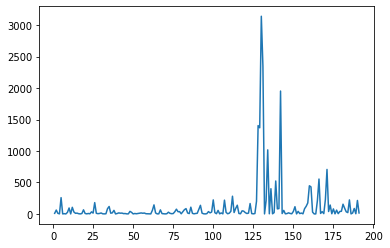

In [46]:
# STR = "CE_NIFTY_ATM"

# bm_loss = np.square(np.array(loss_df_dict[STR]["Loss_constVol_linear"]).reshape(-1))
# sb,cb = single_optimal_block(bm_loss)

# plt.plot(np.arange(1, 192), bm_loss)
# plt.show()

# # model_loss = np.square(np.array(loss_df_dict[STR][alternative_models]))
# #Loss_constVol_linear,CE_NIFTY_ATM,
# # gen = np.random.default_rng(23456)
# # # Common seed used throughout
# # seed = gen.integers(0, 2 ** 31 - 1)

# # (benchmark, models, block_size=None, reps=1000, \
# #  bootstrap='stationary', \
# #  studentize=True, nested=False)
# # If block_size is none, then, it takes sqrt(T) has block size.

# # spa = SPA(bm_loss, model_loss, block_size=sb, reps=1000, \
# #           bootstrap='stationary', studentize=True, nested=False)
# # spa.compute()
# # spa.pvalues


# # print(alternative_models)


In [10]:
bm_loss = np.random.rand(100,1)
model_loss = np.random.rand(100,10) + np.linspace(-0.5, 2, num=10)
spa = SPA(bm_loss, model_loss, block_size=5, reps=1000, \
          bootstrap='stationary', studentize=True, nested=False)
spa.compute()
spa.pvalues

lower         0.0
consistent    0.0
upper         0.0
dtype: float64

In [138]:
# bm_loss = np.square(np.array(loss_df_dict["CE_NIFTY_ATM"]["Loss_constVol_linear"]).reshape(-1))
# sb,cb = single_optimal_block(bm_loss)

# model_loss = np.square(np.array(loss_df_dict["CE_NIFTY_ATM"][carr_alt_model]))


# gen = np.random.default_rng(23456)
# # Common seed used throughout
# seed = gen.integers(0, 2 ** 31 - 1)

# spa = SPA(bm_loss, model_loss, seed=seed, block_size=sb, reps=1000, \
#           bootstrap='stationary', studentize=True, nested=False)
# spa.compute()
# spa.pvalues

In [126]:
# for intrpl_id in intrpl_id_list:
#     benchmark = 'Loss_dynamic_' + intrpl_id

#     for key in loss_df_dict.keys():
# #         df = loss_df_dict[key]
#         print(key.split("_"))

In [158]:
# df_sample = df_hedge_loss[(df_hedge_loss["Index"] == "BANKNIFTY") &  \
#                           (df_hedge_loss["Option Type"] == "CE") & \
#                           (df_hedge_loss["Moneyness"] == "ATM") & \
#                           (df_hedge_loss["Interpolation Type"] == "Cubic Polynomial Fit")]

# bm_loss = np.square(np.array(df_sample["Loss_dynamic"]).reshape(-1,1))
# model_loss = np.square(np.array(df_sample[["Loss_constVol", "Loss_constSmile", "Loss_constSurf", "Loss_fwdSmile"]]))


# bm_loss = (np.array(df_sample[["Loss_constVol"]]))
# model_loss = (np.array(df_sample["Loss_dynamic"]).reshape(-1,1))

# print(bm_loss.shape)
# print(model_loss.shape)

# gen = np.random.default_rng(23456)
# # Common seed used throughout
# seed = gen.integers(0, 2 ** 31 - 1)

# spa = SPA(bm_loss, model_loss, seed=seed)
# spa.compute()
# spa.pvalues


In [ ]:
# # SPA Analysis code

# # Null: Performance of static hedge is not better than dynamic hedge
# # Dynamic hedge is benchmark model
# #CALL -ATM - NIFTY



# df_sample = df_hedge_loss[(df_hedge_loss["Index"] == "BANKNIFTY") &  \
#                           (df_hedge_loss["Option Type"] == "CE") & \
#                           (df_hedge_loss["Moneyness"] == "ATM") & \
#                           (df_hedge_loss["Interpolation Type"] == "Cubic Polynomial Fit")]

# #Benchmark is Dynamic Hedging. constVol, constSmile, constSurf, fwdSmile are alternative models
# df_sample["perf_t_constVol"] = df_sample["Loss_dynamic"] - df_sample["Loss_constVol"]
# df_sample["perf_t_constSmile"] = df_sample["Loss_dynamic"] - df_sample["Loss_constSmile"]
# df_sample["perf_t_constSurf"] = df_sample["Loss_dynamic"] - df_sample["Loss_constSurf"]
# df_sample["perf_t_fwdSmile"] = df_sample["Loss_dynamic"] - df_sample["Loss_fwdSmile"]

# X = np.array(df_sample["Loss_dynamic"]).reshape(-1)
# stat_block_length, cir_block_length = single_optimal_block(X)
# stat_block_length = np.ceil(stat_block_length)
# cir_block_length = np.ceil(cir_block_length)

# no_of_samples = df_sample.shape[0]
# B = 100

# stat_bootstrap_indices = generate_stationary_bootstrap_indices(no_of_samples, B, stat_block_length).astype(int)

# perf_constVol = np.array(df_sample["perf_t_constVol"]).reshape(-1)
# perf_constSmile = np.array(df_sample["perf_t_constSmile"]).reshape(-1)
# perf_constSurf = np.array(df_sample["perf_t_constSurf"]).reshape(-1)
# perf_fwdSmile = np.array(df_sample["perf_t_constSurf"]).reshape(-1)

# perf_constVol_mean = np.mean(perf_constVol)
# perf_constSmile_mean = np.mean(perf_constSmile)
# perf_constSurf_mean = np.mean(perf_constSurf)
# perf_fwdSmile_mean = np.mean(perf_fwdSmile)

# # Generate Bootstrap samples
# bootstraps_constVol = np.take(perf_constVol, stat_bootstrap_indices)
# bootstraps_constSmile = np.take(perf_constSmile, stat_bootstrap_indices)
# bootstraps_constSurf = np.take(perf_constSurf, stat_bootstrap_indices)
# bootstraps_fwdSmile = np.take(perf_fwdSmile, stat_bootstrap_indices)

# #SPA and RC statistics

# def kernel_coeff(n, prb, i):
#     return ((n-i) / n) * ((1-prb)^i)  +  (i/n) * ((1-prb)^(n-i))












In [71]:
# B = 3 # Number of bootstrap samples
# block_size = 2
# n = 5
# X = np.array([1,2,3,4,5]) # data [n,1]


# X_concat = np.array(list(X)* B) # concatenated data [nxb,1]
# print(X_concat)
# block_array = np.array(list(generate_subsets(X_concat,block_size)))
# print(block_array)
# perm_index_array =  np.random.permutation(range(len(block_array)))
# print(perm_index_array)
# print(block_array[perm_index_array])
# perm_block_array =  np.concatenate(block_array[perm_index_array])
# print(perm_block_array)
# block_array = np.array(list(generate_subsets(perm_block_array,n)))
# print(block_array)



In [72]:
# a = np.array([0,1.0,2,3,4,5])

# ind = np.array([[1,3,5], [4,5,0]]).reshape(2,3)
# b = np.take(a, ind)
# print(b.shape)
# print(b)

In [ ]:
# #Generate Subsets
# def generate_subsets(time_series,block_size):
#     for i in range(0,len(time_series),block_size):
#         yield time_series[i:i+block_size]

# # Generate Jeff Circular Bootstrap indices
# def generate_circular_bootstrap_indices_jeff(no_of_samples, B, block_size):
#     data = np.arange(no_of_samples)
#     data_concat = np.array(list(data)* B)
#     data_blocks = np.array(list(generate_subsets(data_concat,block_size)))
#     perm_index_array = np.random.permutation(range(len(data_blocks)))
#     perm_data_blocks =  np.concatenate(data_blocks[perm_index_array])
#     circularbootstrapped_samples = np.array(list(generate_subsets(perm_block_array,n)))
#     return circularbootstrapped_samples
        
# # Generate Stationary Bootstrap indices
# def generate_stationary_bootstrap_indices(no_of_samples, B, block_size):
#     #Define the probability of a new block
#     prb=1/block_size;
#     indices=np.zeros((no_of_samples,B))
#     #Initial positions
#     indices[0,:] = np.ceil(np.random.uniform(0, no_of_samples, B))
#     # Set up the random numbers
#     select=np.random.uniform(0, 1, (no_of_samples,B))<prb
#     indices[select]=np.ceil(np.random.uniform(0, no_of_samples, np.sum(select)))
#     for i in range(1,no_of_samples):
#     # Determine whether we stay (rand>p) or move to a new starting value
#     # (rand<p)
#         indices[i,~select[i,:]]=indices[i-1,~select[i,:]]+1
        
#     indices[indices>(no_of_samples-1)] = indices[indices>(no_of_samples-1)]-(no_of_samples-1)
#     return indices
    
    

In [ ]:
# case_list = list(itertools.product(e_Series, prod_moneyness_list, prod_type_list, stock_ident_list))

# # NIFTY BANKNIFTY; CALL PUT; ATM ITM OTM;
# # Losses - (All Option: Dynamic, CVOL, CSMILE, CSURF, FSMILE; Only Call: CarrWu) * (LINEAR_INTP, CUBIC_SPLINE, CUBIC_POLYN, QUAD_POLYN)

# list_of_call_nifty_atm_dfs = []
# list_of_call_nifty_itm_dfs = []
# list_of_call_nifty_otm_dfs = []
# list_of_put_nifty_atm_dfs = []
# list_of_put_nifty_itm_dfs = []
# list_of_put_nifty_otm_dfs = []

# list_of_call_banknifty_atm_dfs = []
# list_of_call_banknifty_itm_dfs = []
# list_of_call_banknifty_otm_dfs = []
# list_of_put_banknifty_atm_dfs = []
# list_of_put_banknifty_itm_dfs = []
# list_of_put_banknifty_otm_dfs = []

# for case in case_list:
#     if (case[1] == 'A'):
#         prod_moneyness = "ATM"
#     if (case[1] == 'I'):
#         prod_moneyness = "ITM"    
#     if (case[1] == 'O'):
#         prod_moneyness = "OTM"
#     if (case[2] == 'C'):
#         prod_type = "CE"
#     if (case[2] == 'P'):
#         prod_type = "PE"
        
#     if (case[0] in ["0", "1A"]):
#         interpolation_type = "Linear Interpolation"
#     if (case[0] in ["0A", "2A"]):
#         interpolation_type = "Cubic Spline Interpolation"
#     if (case[0] in ["0B", "3A"]):
#         interpolation_type = "Cubic Polynomial Fit"
#     if (case[0] in ["0C", "4A"]):
#         interpolation_type = "Quadratic Polynomial Fit"
    
#     stock_ident = case[3]

#     if (case[0] in ["0", "0A", "0B", "0C"] and prod_type =="CE"):
#         filename = output_data_path + "E" + case[0] + "_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_hedge_results" + ".csv"

#         df_hedge_data = pd.read_csv(filename)
#         no_of_rows = df_hedge_data.shape[0]        

#         df_hedge_data['Loss_dynamic'] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - Dynamic'])
#         df_hedge_data['Loss_constVol'] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVol'])
#         df_hedge_data['Loss_carrWu'] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - CarrWu'])
        
#         index = [stock_ident for i in range(0, no_of_rows)]
#         moneyness = [prod_moneyness for i in range(0, no_of_rows)]
#         prodtype = [prod_type for i in range(0, no_of_rows)]
#         intpltype = [interpolation_type for i in range(0, no_of_rows)]
        
        
#         df_hedge_data["Interpolation Type"] = intpltype
#         df_hedge_data["Moneyness"] = moneyness
#         df_hedge_data["Option Type"] = prodtype   
#         df_hedge_data["Index"] = index
        
#         df_loss_data = df_hedge_data[["Date", "Index", "Interpolation Type", "Option Type", "Moneyness", "Loss_dynamic", "Loss_constVol", "Loss_carrWu"]]
#         list_of_carrWu_dfs.append(df_loss_data)
        
#     if (case[0] in ["1A", "2A", "3A", "4A"]):
#         filename = output_data_path + "E" + case[0] + "_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_hedge_results" + ".csv"
        
#         df_hedge_data = pd.read_csv(filename)
#         no_of_rows = df_hedge_data.shape[0]


#         df_hedge_data['Loss_dynamic'] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - Dynamic'])
#         df_hedge_data['Loss_constVol'] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVol'])
#         df_hedge_data['Loss_constSmile'] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVolSmile'])
#         df_hedge_data['Loss_constSurf'] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - ConstVolSurf'])
#         df_hedge_data['Loss_fwdSmile'] = np.absolute(df_hedge_data['Pfl PnL - Realised'] - df_hedge_data['Pfl PnL - FwdSmile'])
        
#         index = [stock_ident for i in range(0, no_of_rows)]
#         moneyness = [prod_moneyness for i in range(0,no_of_rows)]
#         prodtype = [prod_type for i in range(0,no_of_rows)]
#         intpltype = [interpolation_type for i in range(0, no_of_rows)]
        
#         df_hedge_data["Interpolation Type"] = intpltype
#         df_hedge_data["Moneyness"] = moneyness
#         df_hedge_data["Option Type"] = prodtype
#         df_hedge_data["Index"] = index
        
#         df_loss_data = df_hedge_data[["Date", "Index", "Interpolation Type", "Option Type", "Moneyness", "Loss_dynamic", "Loss_constVol", \
#                                       "Loss_constSmile", "Loss_constSurf", "Loss_fwdSmile"]]
    
#         list_of_other_dfs.append(df_loss_data)
    
# df_carrWu_loss = pd.concat(list_of_carrWu_dfs, axis=0)
# df_hedge_loss = pd.concat(list_of_other_dfs, axis=0)
    
# df_carrWu_loss.to_csv(output_data_path + "F2" + "_carrWu_losses" + ".csv", index = False)
# df_hedge_loss.to_csv(output_data_path + "F2" + "_static_hedge_losses" + ".csv", index = False)

